Based on the 'activation maximization' technique suggested in [this](https://pdfs.semanticscholar.org/65d9/94fb778a8d9e0f632659fb33a082949a50d3.pdf) paper. 

We will view the layers of the (pretrained) GoogLeNet just like in [this](https://distill.pub/2017/feature-visualization/) post.

## Import useful libraries 

In [1]:
import torch

In [2]:
torch.cuda.is_available()

True

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from torchvision import models

## Import a pretrained GoogLeNet

In [4]:
model = models.googlenet(pretrained = True)

model

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [5]:
# We now freeze the parameters of our pretrained model
for param in model.parameters():
    param.requires_grad_(False)

In [6]:
# layer: inception4a
model.inception4a

Inception(
  (branch1): BasicConv2d(
    (conv): Conv2d(480, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (branch2): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(480, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(96, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicConv2d(
      (conv): Conv2d(96, 208, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(208, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (branch3): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(480, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicConv2d(
      (conv): Conv2d(16, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): Batc

In [7]:
# We will register a forward hook to get the output of the layers

activation = {} # to store the activation  of a layer
def create_hook(name):
    def hook(m, i, o):
        # copy the output of the given layer
        activation[name] = o
       
    return hook


# register a forward hook for layer 3a i.e. the first inception layer
model.inception4a.register_forward_hook(create_hook('4a'))

## Create an input image 

The starting image will consist of random values for the pixels

In [8]:
# normalize the input image to have appropriate mean and standard deviation as specified by pytorch
from torchvision import transforms



normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [9]:
# generating the initial image with random pixel values between 0 and 1
H = 224 # height of input image
W = 224 # width of input image
img = np.single(np.random.uniform(0,1, (3, H, W)))
print("img_shape:{}, img_dtype: {}".format(img.shape, img.dtype ))
# convert the image to a torch tensor with the requisite mean and std. dev. 
img_tensor = normalize(torch.from_numpy(img))
print(img_tensor)

img_shape:(3, 224, 224), img_dtype: float32
tensor([[[ 1.5104e+00,  5.1758e-01, -1.9730e-01,  ...,  8.2885e-01,
          -5.5629e-01, -1.0292e+00],
         [-1.1537e+00,  1.5596e+00, -1.0742e+00,  ..., -6.1450e-01,
          -4.0684e-01, -1.8374e+00],
         [-1.1195e+00, -2.0334e+00,  1.0434e+00,  ...,  1.9312e+00,
           2.0666e+00,  1.7455e-01],
         ...,
         [ 1.4109e+00,  7.4034e-01,  1.7419e+00,  ...,  1.5168e+00,
           1.6072e+00,  1.6218e+00],
         [-6.5927e-01, -1.5329e+00, -9.3329e-01,  ..., -8.1902e-01,
           8.8344e-01, -5.2212e-01],
         [-1.9390e+00,  4.0403e-01, -5.0121e-01,  ...,  1.2466e+00,
           3.2306e-01,  2.0330e+00]],

        [[ 2.3201e+00, -1.2886e+00,  9.3871e-01,  ...,  2.0060e+00,
           6.4196e-01,  1.9497e+00],
         [-9.0688e-01,  1.8790e+00, -7.8491e-01,  ..., -9.0672e-03,
           1.2961e+00,  1.4008e+00],
         [-1.9159e+00, -1.8054e+00,  3.8400e-01,  ...,  2.3283e-01,
           1.4401e+00, -7.5690e-

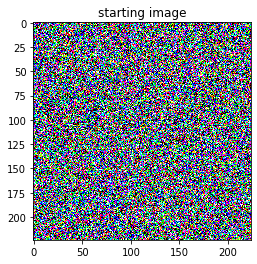

In [10]:
# function to massage img_tensor for using as input to plt.imshow()
def image_convertor(im):
    
    # for plt.imshow() the channel-dimension is the last
    # therefore use transpose to permute 
    im_copy = im.clone().detach().numpy().transpose(1,2,0)
    # clip negative values as plt.imshow() only accepts 
    # floating values in range [0,1] and integers in range [0,255]
    im_copy = im_copy.clip(0, 1) 
    
    return im_copy

plt.imshow(image_convertor(img_tensor))                                                               
plt.title('starting image')
plt.show()

In [11]:
from torch import optim

In [12]:
# move the model and input image to the GPU (if available) 
# This should be done before defining an optimizer
# This is mentioned in the following pytorch page: https://pytorch.org/docs/master/optim.html
# Also see the discussion here: https://discuss.pytorch.org/t/effect-of-calling-model-cuda-after-constructing-an-optimizer/15165/7
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Calculations being executed on {}'.format(device))

model.to(device)
img_tensor = img_tensor.to(device).requires_grad_(True) # move the image tensor to cuda 
                                                        # set its requires_grad_ flag to be true

# check that the model and img_tensor are on cuda or not
# https://discuss.pytorch.org/t/how-to-check-if-model-is-on-cuda/180
print('googlenet is on cuda: {}'.format(next(model.parameters()).is_cuda))
print('img_tensor is on cuda: {}'.format(img_tensor.is_cuda))

optimizer = optim.Adam([img_tensor], lr =0.04)

Calculations being executed on cuda
googlenet is on cuda: True
img_tensor is on cuda: True


epoch: 0/10000, activation: 1137.5322265625


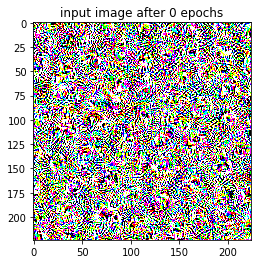

epoch: 1000/10000, activation: 1252.9237060546875


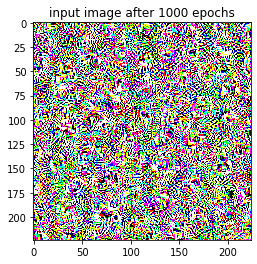

epoch: 2000/10000, activation: 1368.8052978515625


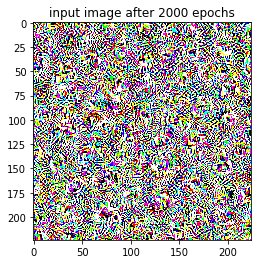

epoch: 3000/10000, activation: 1485.12841796875


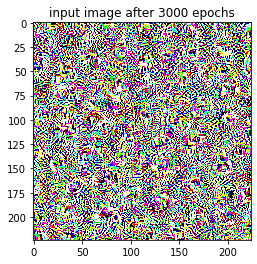

epoch: 4000/10000, activation: 1601.50537109375


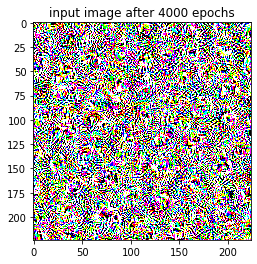

epoch: 5000/10000, activation: 1718.3162841796875


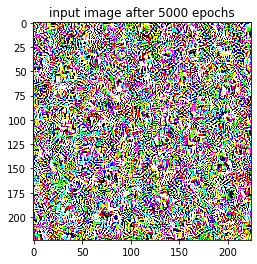

epoch: 6000/10000, activation: 1835.2890625


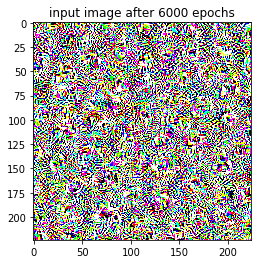

epoch: 7000/10000, activation: 1952.3594970703125


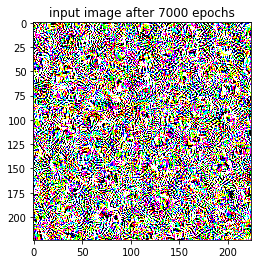

epoch: 8000/10000, activation: 2069.769287109375


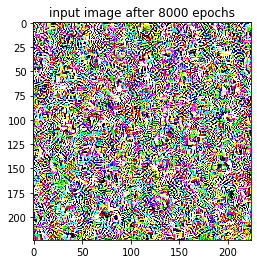

epoch: 9000/10000, activation: 2187.38623046875


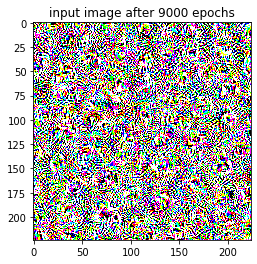

In [14]:
# Since we are not training googlenet here, therefore we should use evaluation mode 
# this is because batch-normalization layers in googlenet will have different behaviour in traning vs evaluation modes
model.eval()


num_epochs = 10000
display_every = 1000
unit_idx = 11 # unit of the convolution layer that we wish to visualize

for epoch in range(num_epochs):
    
    optimizer.zero_grad()
    model(img_tensor.unsqueeze(0))
    layer_out = activation['4a']
    loss = -layer_out[0, unit_idx].mean() 
    loss.backward()
    optimizer.step()
    # normalize the updated img_tensor to have pytorch specified mean and std. dev.
    # img_tensor = normalize(img_tensor.clone().detach()).requires_grad_(True)
    # the above step of renormalizing the updated img_tensor does not work: the activation remains frozen at ~ 2.368 and no patterns seem to develop in the image
    # Will have to understand this further  
    
    if epoch % display_every == 0:
        print('epoch: {}/{}, activation: {}'.format(epoch, num_epochs, -loss))
        plt.imshow(image_convertor(img_tensor.cpu()))
        plt.title('input image after {} epochs'.format(epoch))
        plt.show()


The final image does seeem to have some very high frequency patterns. However, the high frequency behaviour obscures any interpretation of what the neuron seems to learning. 

I found that my code above is quite similar to the implementation of feature visualization with activation maximization in [this](https://towardsdatascience.com/how-to-visualize-convolutional-features-in-40-lines-of-code-70b7d87b0030) blog post. There the author also discusses the emerges of high frequence patterns in the image and how he got around it by initially feeding smaller sized images and slowing upscaling them. 